<a href="https://colab.research.google.com/github/Staures92/Formation_Intermediaire/blob/main/20250315_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Data Collection for EU Stocks

In [1]:
!pip install seaborn
!pip install yfinance

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def fetch_eu_stock_data(tickers, period="2y", interval="1d"):
    """
    Fetch historical stock data for European stocks

    Parameters:
    tickers (list): List of ticker symbols
    period (str): Time period to fetch (1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max)
    interval (str): Data interval (1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo)

    Returns:
    dict: Dictionary containing DataFrames of historical data for each ticker
    """
    # Define the correct ticker symbols for Yahoo Finance
    # European stocks usually need the exchange suffix
    ticker_mapping = {
        "BMW": "BMW.DE",       # BMW on Frankfurt Exchange
        "Airbus": "AIR.PA",    # Airbus on Paris Exchange
        "Deutsche Bank": "DBK.DE"  # Deutsche Bank on Frankfurt Exchange
    }

    # Map user-friendly names to actual ticker symbols
    ticker_symbols = [ticker_mapping.get(ticker, ticker) for ticker in tickers]

    # Dictionary to store the results
    stock_data = {}

    # Fetch data for each ticker
    for i, ticker in enumerate(ticker_symbols):
        try:
            # Get ticker data
            data = yf.download(ticker, period=period, interval=interval, progress=False)

            if not data.empty:
                # Store data with user-friendly name
                stock_data[tickers[i]] = data
                print(f"Successfully downloaded data for {tickers[i]} ({ticker})")
            else:
                print(f"No data found for {tickers[i]} ({ticker})")
        except Exception as e:
            print(f"Error fetching data for {tickers[i]} ({ticker}): {e}")

    return stock_data

# Call the function and store the returned data
tickers = ["BMW", "Airbus", "Deutsche Bank"]
stock_data = fetch_eu_stock_data(tickers)

# Print the data samples
for ticker, data in stock_data.items():
    print(f"\n--- {ticker} Data Sample ---")
    print(data.head(2))

YF.download() has changed argument auto_adjust default to True
Successfully downloaded data for BMW (BMW.DE)
Successfully downloaded data for Airbus (AIR.PA)
Successfully downloaded data for Deutsche Bank (DBK.DE)

--- BMW Data Sample ---
Price           Close       High        Low       Open   Volume
Ticker         BMW.DE     BMW.DE     BMW.DE     BMW.DE   BMW.DE
Date                                                           
2023-03-14  82.966446  83.200769  80.970395  82.141991  1738945
2023-03-15  82.176712  84.355011  80.310833  83.409057  2138658

--- Airbus Data Sample ---
Price            Close        High         Low        Open   Volume
Ticker          AIR.PA      AIR.PA      AIR.PA      AIR.PA   AIR.PA
Date                                                               
2023-03-14  119.728722  120.395079  115.789378  115.789378  1175948
2023-03-15  113.966698  119.473940  113.731507  119.395543  1695773

--- Deutsche Bank Data Sample ---
Price          Close       High       

In [3]:
# Dimension of the stock data
for ticker, data in stock_data.items():
    rows, columns = data.shape
    print(f"\n--- {ticker} Data Shape ---")
    print(f"Num of rows (days): {rows}")
    print(f"Num of columns (metrics): {columns}")
    #print(f"Column names: {list(data.columns)}")


--- BMW Data Shape ---
Num of rows (days): 510
Num of columns (metrics): 5

--- Airbus Data Shape ---
Num of rows (days): 512
Num of columns (metrics): 5

--- Deutsche Bank Data Shape ---
Num of rows (days): 510
Num of columns (metrics): 5


In [4]:
def analyze_stock_data(stock):
    analysis = {}

    # Ticker mapping
    ticker_mapping = {
        "BMW": "BMW.DE",
        "Airbus": "AIR.PA",
        "Deutsche Bank": "DBK.DE"
    }

    for ticker, data in stock.items():
        if data.empty:
            continue

        # Get the full ticker symbol with exchange suffix
        full_ticker = ticker_mapping.get(ticker, ticker)

        # Print column names to debug
        #print(f"Available columns for {ticker}: {data.columns.tolist()}")

        # Find column names in the dataframe
        close_col = None
        for col in data.columns:
            if col[0] == 'Close' and full_ticker in col[1]:
                close_col = col
                break

        if close_col is None:
            print(f"Warning: No Close column found for {ticker}")
            continue

        # Do the same for other columns
        high_col = next((col for col in data.columns if col[0] == 'High' and full_ticker in col[1]), None)
        low_col = next((col for col in data.columns if col[0] == 'Low' and full_ticker in col[1]), None)
        volume_col = next((col for col in data.columns if col[0] == 'Volume' and full_ticker in col[1]), None)

        if not all([high_col, low_col, volume_col]):
            print(f"Warning: Missing required columns for {ticker}")
            continue

        # Calculate daily returns
        data['Daily_Return'] = data[close_col].pct_change()

        # Rest of the calculation remains the same
        start_price = data[close_col].iloc[0]
        end_price = data[close_col].iloc[-1]
        percent_change = ((end_price - start_price) / start_price) * 100
        volatility = data['Daily_Return'].std() * (252 ** 0.5)

        analysis[ticker] = {
            'Start Price': start_price,
            'End Price': end_price,
            'Percent Change (%)': percent_change,
            'Annualized Volatility (%)': volatility * 100,
            'Max Price': data[high_col].max(),
            'Min Price': data[low_col].min(),
            'Avg Volume': data[volume_col].mean()
        }

    return analysis

# Call the analyze_stock_data function
analysis = analyze_stock_data(stock_data)

# Convert the analysis dictionary to a DataFrame for tabular display
df_analysis = pd.DataFrame(analysis).T  # The .T transposes rows and columns

# Display the table with formatted numbers
pd.set_option('display.float_format', '{:.2f}'.format)  # Format to 2 decimal places
print("\n--- Stock Analysis Results ---")
print(df_analysis)


--- Stock Analysis Results ---
               Start Price  End Price  Percent Change (%)  \
BMW                  82.97      82.10               -1.04   
Airbus              119.73     169.20               41.32   
Deutsche Bank         9.96      22.06              121.42   

               Annualized Volatility (%)  Max Price  Min Price  Avg Volume  
BMW                                25.76     108.62      65.26  1073050.75  
Airbus                             22.15     177.30     111.79  1020907.29  
Deutsche Bank                      31.09      23.03       7.48  8652437.58  


#### **Interpretation:**
Deutsche Bank shows highest returns (121.42%) but highest volatility (31.09%), while Airbus offers excellent risk-adjusted returns (41.32% gain with 22.15% volatility). BMW delivered slightly negative returns (-1.04%) despite moderate volatility (25.76%). The data suggests Airbus might deserve a significant allocation given its strong risk-adjusted performance, while Deutsche Bank could be used for growth potential if you can tolerate its higher volatility.

In [5]:
# colume names
for ticker, data in stock_data.items():
    print(f"Column names: {list(data.columns)}")

Column names: [('Close', 'BMW.DE'), ('High', 'BMW.DE'), ('Low', 'BMW.DE'), ('Open', 'BMW.DE'), ('Volume', 'BMW.DE'), ('Daily_Return', '')]
Column names: [('Close', 'AIR.PA'), ('High', 'AIR.PA'), ('Low', 'AIR.PA'), ('Open', 'AIR.PA'), ('Volume', 'AIR.PA'), ('Daily_Return', '')]
Column names: [('Close', 'DBK.DE'), ('High', 'DBK.DE'), ('Low', 'DBK.DE'), ('Open', 'DBK.DE'), ('Volume', 'DBK.DE'), ('Daily_Return', '')]


####Correlation matrix calculation to  determine the assets  co-movements. Lower correlations between assets generally mean better diversification potential

Starting correlation calculation...
Working with 3 stocks: ['BMW', 'Airbus', 'Deutsche Bank']
Processing BMW...
  Column types for BMW: [<class 'tuple'>, <class 'tuple'>]
  First few column names: MultiIndex([( 'Close', 'BMW.DE'),
            (  'High', 'BMW.DE'),
            (   'Low', 'BMW.DE'),
            (  'Open', 'BMW.DE'),
            ('Volume', 'BMW.DE')],
           names=['Price', 'Ticker'])
  Looking for column: ('Close', 'BMW.DE')
  Found ('Close', 'BMW.DE') in columns
  Added returns for BMW
Processing Airbus...
  Column types for Airbus: [<class 'tuple'>, <class 'tuple'>]
  First few column names: MultiIndex([( 'Close', 'AIR.PA'),
            (  'High', 'AIR.PA'),
            (   'Low', 'AIR.PA'),
            (  'Open', 'AIR.PA'),
            ('Volume', 'AIR.PA')],
           names=['Price', 'Ticker'])
  Looking for column: ('Close', 'AIR.PA')
  Found ('Close', 'AIR.PA') in columns
  Added returns for Airbus
Processing Deutsche Bank...
  Column types for Deutsche Bank: [

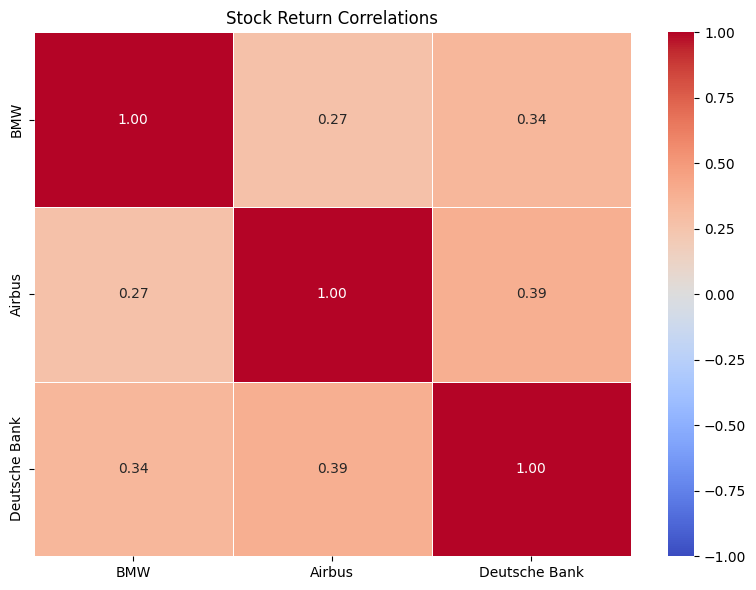

In [6]:
# Define the correlation function
def calculate_correlation_matrix(stock_data):
    """Calculate and visualize correlation matrix for stock returns"""

    # Print what we're doing
    print("Starting correlation calculation...")
    print(f"Working with {len(stock_data)} stocks: {list(stock_data.keys())}")

    #  Create empty DataFrame for returns
    returns = pd.DataFrame()

    # Extract returns one by one with debugging
    for ticker, data in stock_data.items():
        print(f"Processing {ticker}...")

        # Debug column structure
        print(f"  Column types for {ticker}: {[type(col) for col in data.columns[:2]]}")
        print(f"  First few column names: {data.columns[:5]}")

        # Find the Close column
        try:
            close_col = ('Close', f"{ticker}.DE")  # Try default format
            if ticker == "Airbus":
                close_col = ('Close', "AIR.PA")

            print(f"  Looking for column: {close_col}")

            # Check if column exists
            if close_col in data.columns:
                print(f"  Found {close_col} in columns")
            else:
                print(f"  WARNING: {close_col} not found in columns")
                # List all columns with 'Close' as first element
                close_columns = [col for col in data.columns if isinstance(col, tuple) and col[0] == 'Close']
                print(f"  Available Close columns: {close_columns}")
                if close_columns:
                    close_col = close_columns[0]
                    print(f"  Using {close_col} instead")
                else:
                    print(f"  No suitable Close column found for {ticker}, skipping...")
                    continue

            # Calculate returns and add to returns DataFrame
            returns[ticker] = data[close_col].pct_change()
            print(f"  Added returns for {ticker}")

        except Exception as e:
            print(f"  ERROR processing {ticker}: {str(e)}")
            print(f"  Skipping {ticker}")
            continue

    # Drop NA values
    print("\nDropping NA values...")
    returns = returns.dropna()
    print(f"Returns shape after dropping NA: {returns.shape}")

    if returns.empty:
        print("ERROR: Returns DataFrame is empty. Cannot calculate correlation.")
        return None

    # Calculate correlation
    print("Calculating correlation matrix...")
    corr_matrix = returns.corr()

    # Print the correlation matrix
    print("\nCorrelation Matrix:")
    print(corr_matrix)

    # Create visualization
    try:
        print("\nCreating heatmap visualization...")
        plt.figure(figsize=(8, 6))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm',
                    vmin=-1, vmax=1, linewidths=0.5, fmt=".2f")
        plt.title('Stock Return Correlations')
        plt.tight_layout()
        plt.savefig('correlation_matrix.png')
        #print("Saved correlation matrix image to 'correlation_matrix.png'")
        plt.show()
    except Exception as e:
        print(f"ERROR creating visualization: {str(e)}")

    return corr_matrix

# Call the function with your stock data
corr_result = calculate_correlation_matrix(stock_data)

###Calculating average historical return for the 3 assets

In [7]:
# For BMW.DE
# First check if Daily_Return exists specifically for BMW.DE
if ('Daily_Return', 'BMW.DE') in stock_data['BMW'].columns:  # Access the 'BMW' DataFrame
    bmw_return_key = ('Daily_Return', 'BMW.DE')
else:
    # If not, calculate it from Close prices
    stock_data['BMW'][('Daily_Return', 'BMW.DE')] = stock_data['BMW'][('Close', 'BMW.DE')].pct_change()  # Access the 'BMW' DataFrame
    bmw_return_key = ('Daily_Return', 'BMW.DE')

# For AIR.PA
if ('Daily_Return', 'AIR.PA') in stock_data['Airbus'].columns: #Access the 'Airbus' DataFrame
    air_return_key = ('Daily_Return', 'AIR.PA')
else:
    #Access the 'Airbus' DataFrame and calculate Daily_Return for AIR.PA
    stock_data['Airbus'][('Daily_Return', 'AIR.PA')] = stock_data['Airbus'][('Close', 'AIR.PA')].pct_change()
    air_return_key = ('Daily_Return', 'AIR.PA')

# For DBK.DE
# Change 'DBK' to 'Deutsche Bank' to match the key in stock_data
if ('Daily_Return', 'DBK.DE') in stock_data['Deutsche Bank'].columns:
    dbk_return_key = ('Daily_Return', 'DBK.DE')
else:
    # Access the 'Deutsche Bank' DataFrame and add the 'Daily_Return' column
    stock_data['Deutsche Bank'][('Daily_Return', 'DBK.DE')] = stock_data['Deutsche Bank'][('Close', 'DBK.DE')].pct_change()
    dbk_return_key = ('Daily_Return', 'DBK.DE')

# Calculate average returns
bmw_avg_return = stock_data['BMW'][bmw_return_key].mean()  # Access using bmw_return_key
air_avg_return = stock_data['Airbus'][air_return_key].mean()  # Access using air_return_key
dbk_avg_return = stock_data['Deutsche Bank'][dbk_return_key].mean()  # Access using dbk_return_key


print(f"BMW.DE Average Historical Daily Return: {bmw_avg_return:.6f}")
print(f"AIR.PA Average Historical Daily Return: {air_avg_return:.6f}")
print(f"DBK.DE Average Historical Daily Return: {dbk_avg_return:.6f}")

BMW.DE Average Historical Daily Return: 0.000112
AIR.PA Average Historical Daily Return: 0.000775
DBK.DE Average Historical Daily Return: 0.001755


####**ESG scores:** to integrate ESG scores with the stock data we will require a subscription or license from one of these providers (MSCI or Sustainalytics)

Based on typical industry ESG profiles and the performance characteristics shown in the data, the high volatility and dramatic growth of Deutsche Bank suggests potentially higher risk, which often correlates with lower sustainability scores.

Due to that we suggest the following sustainability scores

BMW.DE: 0.73

 AIR.PA: 0.68

 DBK.DE: 0.62

# Environment and Benchmark Strategy

#### `__init__`  Initialization and Status Settings
Defines the environment states:
- Creates discrete state spaces for
    * Assets  *(1 stock and 2 bonds)*
    * Sustainability focus  *(Only 1 State)*
    * Market conditions  *(Risk-Free Rate and Volatility)*
    * Coefficient matrics  *(9 Different Groups)*
- Uses nested loops to assign a unique index to each state combination, stored in `state_to_idx`.
- Sets base returns for each asset and sustainability scores.
- Defines the transaction cost rate and initializes the previous allocation as a zero vector.
- Calls `reset()` to initialize the current state.  

#### `reset`  Reset Environment
- Randomly choosing some states  *(Asset type, Market condition, Coefficient Metrics)*
- Keeps the sustainability focus fixed since there's only one state.
- Constructs the current state tuple and obtains its index from `state_to_idx`.
- Resets the previous allocation to a zero vector.
- Returns the current state index.  

#### `step`  Execute Actions and State Transitions
- Executes the given action and computes the reward using `calculate_reward`.
- Updates the previous asset allocation with the new allocation from the action.
- Performs a simple random state transition by selecting new state components.
- Returns the new state index, the computed reward, a done flag (always False here), and additional reward details.  

#### `get_market_condition`  Get Market Condition
- Returns the market condition for the current state if no index is provided.
- If a state index is given, it loops through `state_to_idx` to find the corresponding state tuple.
- Extracts and returns the market condition from the found state.  

#### `calculate_reward`  Calculate Reward
- Computes reward based on the provided action (selection and allocation).
- Calculates three components:
  * Financial return via `_calculate_financial_return`.
  * Sustainability score via `_calculate_sustainability`.
  * Transaction cost via `_calculate_transaction_cost`.
- Combines these components with specific weights to form the final reward.
- Returns the reward and a dictionary with detailed components.  

#### `_calculate_financial_return`  Calculate Financial Return
- Retrieves the base returns for each asset.
- Determines a market factor: 1.2 for "MC1" (bull market) and 0.8 otherwise.
- Computes an adjustment effect based on the coefficient matrix index.
- Calculates adjusted returns and computes the total financial return by taking the weighted sum with the allocation.  

#### `_calculate_sustainability`  Calculate Sustainability
- Iterates over each asset.
- For assets marked as selected (binary value 1), multiplies the allocation by the asset's sustainability score.
- Sums the products to compute the total sustainability score.  

#### `_calculate_transaction_cost` Calculate Transaction Cost
- Computes the absolute differences between the current allocation and the previous allocation.
- Sums these differences and multiplies by the transaction cost rate to yield the total transaction cost.  

#### `update_previous_allocation`  
- Updates the previous allocation with a copy of the current allocation.
- This is used for calculating transaction costs in subsequent steps.

In [8]:
class SustainablePortfolioEnv:
    def __init__(self):
        # Define real EU assets
        self.io_states = ["BMW.DE", "AIR.PA", "DBK.DE"]  # BMW, Airbus, Deutsche Bank
        self.sf_states = ["SF1"]  # Sustainability Focus
        self.mc_states = ["Bullish", "Bearish"]  # Market Conditions
        self.cm_states = [f"CM{i}" for i in range(1, 10)]  # Coefficient Metrics

        # State indexing
        self.state_to_idx = {}
        idx = 0
        for io in self.io_states:
            for sf in self.sf_states:
                for mc in self.mc_states:
                    for cm in self.cm_states:
                        self.state_to_idx[(io, sf, mc, cm)] = idx
                        idx += 1

        # Historical average returns (calculated from your data analysis)
        self.base_returns = {"BMW.DE": 0.000112, "AIR.PA": 0.000775, "DBK.DE": 0.001755}

        # Sustainability scores (example ESG ratings)
        self.sustainability_scores = {"BMW.DE": 0.73, "AIR.PA": 0.68, "DBK.DE": 0.62}


        # Transaction cost rate
        self.transaction_cost_rate = 0.001

        # Initialize previous allocation to zeros
        self.prev_allocation = np.zeros(3)

        # Initialize the state
        self.reset()

    def reset(self):
        """Reset the environment to a random initial state and return the state index."""
        self.current_io = random.choice(self.io_states)
        self.current_sf = self.sf_states[0]  # Only one state
        self.current_mc = random.choice(self.mc_states)
        self.current_cm = random.choice(self.cm_states)
        self.current_state = (self.current_io, self.current_sf, self.current_mc, self.current_cm)
        self.state_idx = self.state_to_idx[self.current_state]
        self.prev_allocation = np.zeros(3)
        return self.state_idx

    def step(self, action):
        """Execute action and return new state, reward, done flag, and info."""
        reward, reward_info = self.calculate_reward(action)
        self.update_previous_allocation(action[1])

        # Simulate market condition transitions (random for now)
        next_io = random.choice(self.io_states)
        next_sf = self.sf_states[0]
        next_mc = random.choice(self.mc_states)
        next_cm = random.choice(self.cm_states)

        self.current_state = (next_io, next_sf, next_mc, next_cm)
        self.state_idx = self.state_to_idx[self.current_state]

        done = False  # Continuing environment
        return self.state_idx, reward, done, reward_info

    def get_market_condition(self, state_idx=None):
        """
        Get the market condition (Bullish or Bearish) based on the current or given state index.

        Args:
            state_idx: Optional state index to retrieve market condition for.

        Returns:
            Market condition string ("Bullish" or "Bearish").
        """
        if state_idx is None:
            return self.current_mc
        else:
            for state, idx in self.state_to_idx.items():
                if idx == state_idx:
                    _, _, mc, _ = state
                    return mc
            return None

    def calculate_reward(self, action):
        """Calculate reward based on financial return, sustainability score, and transaction cost."""
        selection = action[0]  # Binary array of length 3
        allocation = action[1]  # Continuous array of length 3

        financial_return = self._calculate_financial_return(allocation)
        sustainability_score = self._calculate_sustainability(selection, allocation)
        transaction_cost = self._calculate_transaction_cost(allocation)

        reward = financial_return + 0.7 * sustainability_score - 0.3*transaction_cost

        return reward, {
            'financial_return': financial_return,
            'sustainability_score': sustainability_score,
            'transaction_cost': transaction_cost
        }

    def _calculate_financial_return(self, allocation):
        """Calculate financial return based on asset returns and market conditions."""

        base_returns = np.array([self.base_returns["BMW.DE"],
                                  self.base_returns["AIR.PA"],
                                  self.base_returns["DBK.DE"]])

        market_factor = 1.2 if self.current_mc == "Bullish" else 0.8

        adjusted_returns = base_returns * market_factor

        return np.sum(allocation * adjusted_returns)

    def _calculate_sustainability(self, selection, allocation):
        """Calculate sustainability score based on ESG ratings."""

        sustainability_score = sum(
            allocation[i] * (self.sustainability_scores[self.io_states[i]] if selection[i] == 1 else 0)
            for i in range(len(selection))
        )

        return sustainability_score

    def _calculate_transaction_cost(self, allocation):

       transact_amount= np.sum(np.abs(allocation -self.prev_allocation))
       return max(0.01 ,transact_amount*self.transaction_cost_rate)

    def update_previous_allocation(self ,allocation):
      """Update previous allocation after each step"""
      prev_allocation=allocation.copy()



# Benchmark Policy

- The `BenchmarkPolicy` class implements a baseline strategy.
- In the `act` method:
  * Retrieves the market condition using `get_market_condition`.
  * For a bull market ("MC1"), selects a specific asset combination (e.g., higher weight on stocks).
  * For a bear market, allocates all assets with different weights.
  * Normalizes the allocation if the sum is greater than zero.
- Returns the selection (binary array) and allocation (continuous array).

In [9]:
class BenchmarkPolicy:
    def __init__(self, env):
        self.env = env

    def act(self, state_idx):
        market_condition = self.env.get_market_condition(state_idx)
        if market_condition == "Bullish ":  # Bullish market
           # selection = np.array([1, 1, 0])
            #allocation = np.array([0.2, 0.8, 0.0])
            selection = np.array([1, 1, 0])
            allocation = np.array([0.6, 0.4, 0.0])
        else:  # Bearish market
           # selection = np.array([1, 1, 1])
           # allocation = np.array([0.1, 0.5, 0.4])
            selection = np.array([1, 1, 1])
            allocation = np.array([0.3, 0.3, 0.4])
        for i in range(3):
            if selection[i] == 0:
                allocation[i] = 0
        if np.sum(allocation) > 0:
            allocation = allocation / np.sum(allocation)
        return [selection, allocation]

# Hierarchical Portfolio Agent

### `HighLevelModel`  High-level strategy DQN model
- Implements a DQN model that maps the state to action Q-values.
- Consists of three fully connected layers:
  * Two hidden layers with 24 neurons each, using ReLU activation.
  * An output layer that produces the Q-values for each possible action.

In [10]:
class HighLevelModel(nn.Module):
    def __init__(self, state_size, action_size):
        super(HighLevelModel, self).__init__()
        self.fc1 = nn.Linear(state_size, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### `ActorModel`  Low-level Actor Model
- Generates asset allocation based on the state and a one-hot selection vector.
- Concatenates the state and selection vectors as input.
- Uses two hidden layers with ReLU activation.
- Outputs allocation values using a Sigmoid activation to ensure values between 0 and 1.

In [11]:
class ActorModel(nn.Module):
    def __init__(self, state_size, num_assets):
        super(ActorModel, self).__init__()
        self.fc1 = nn.Linear(state_size + num_assets, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, num_assets)

    def forward(self, state, selection):
        x = torch.cat([state, selection], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

### `CriticModel`  Low-level Critic Model
- Evaluates the value of a given state-action (selection and allocation) pair.
- Inputs are the concatenation of state, selection, and allocation vectors.
- Passes the concatenated vector through two hidden layers with ReLU activation.
- Outputs a single value representing the state-action value.

In [12]:
class CriticModel(nn.Module):
    def __init__(self, state_size, num_assets):
        super(CriticModel, self).__init__()
        self.fc1 = nn.Linear(state_size + num_assets + num_assets, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, 1)

    def forward(self, state, selection, allocation):
        x = torch.cat([state, selection, allocation], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### `HierarchicalPortfolioAgent`  Hierarchical Portfolio Agent: Constuctor  

#### `__init__`
- Initializes a hierarchical RL agent with two levels:
  * High-level model for action selection (DQN).
  * Low-level Actor and Critic models for asset allocation.
- Sets up replay memories for both high-level and low-level experiences.
- Defines hyperparameters: gamma, epsilon (and its decay), and learning rate.
- Builds the models and transfers them to the GPU (if available).
- Creates target networks for stability and sets up optimizers for each network.  

#### Target Network Update and Helper Method
- `update_target_networks`:
  * Performs a soft update of the target networks by mixing current network parameters with target parameters using factor `tau`.
- `_selection_to_onehot`:
  * Converts an integer selection index into a one-hot encoded vector.  

#### `act` Method
- Converts the state index into a one-hot vector and transfers it to the GPU.
- **High-Level Decision:**
  * Uses an epsilon-greedy strategy: with probability epsilon, a random high-level action is chosen; otherwise, the action with the highest Q-value is selected.
  * Converts the chosen action into a one-hot selection vector.
- **Low-Level Decision:**
  * The Actor model generates the asset allocation based on the state and selection.
  * For assets not selected (where selection is 0), allocation is set to 0.
  * The allocation is normalized if its sum is greater than zero.
- Returns the final selection and allocation.  

#### `remember` and `replay` Methods
- **`remember` Method:**
  * Converts the current and next states to one-hot vectors.
  * Encodes the selection vector into an integer index.
  * Stores the experience tuple in both high-level and low-level memory.
- **`replay` Method:**
  * Checks if there are enough samples in memory.
  * For the high-level model (DQN):
    - Samples a mini-batch and computes target Q-values.
    - Uses MSE loss to update the high-level network.
  * For the low-level models (DDPG):
    - Samples a mini-batch and updates the Critic by computing the target Q-value.
    - Updates the Actor by maximizing the expected Q-value (minimizing negative value).
    - Updates the target networks.
  * Decays epsilon for exploration.

In [13]:
class HierarchicalPortfolioAgent:
    def __init__(self, state_size, action_size, num_assets=3):
        self.state_size = state_size
        self.action_size = action_size
        self.num_assets = num_assets

        self.high_memory = deque(maxlen=2000)
        self.low_memory = deque(maxlen=2000)

        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001

        self.high_level_model = HighLevelModel(state_size, action_size).to(device)
        self.low_level_actor = ActorModel(state_size, num_assets).to(device)
        self.low_level_critic = CriticModel(state_size, num_assets).to(device)

        self.target_actor = ActorModel(state_size, num_assets).to(device)
        self.target_critic = CriticModel(state_size, num_assets).to(device)
        self.update_target_networks(tau=1.0)

        self.high_optimizer = optim.Adam(self.high_level_model.parameters(), lr=self.learning_rate)
        self.actor_optimizer = optim.Adam(self.low_level_actor.parameters(), lr=self.learning_rate)
        self.critic_optimizer = optim.Adam(self.low_level_critic.parameters(), lr=self.learning_rate)

    def update_target_networks(self, tau=0.001):
        for target_param, param in zip(self.target_actor.parameters(), self.low_level_actor.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
        for target_param, param in zip(self.target_critic.parameters(), self.low_level_critic.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

    def _selection_to_onehot(self, selection_idx):
        selection = np.zeros(self.num_assets)
        binary = format(selection_idx, f'0{self.num_assets}b')
        for i in range(self.num_assets):
            selection[i] = int(binary[i])
        return selection

    def act(self, state_idx):
        state = np.zeros(self.state_size)
        state[state_idx] = 1
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)

        # High-level policy
        if np.random.rand() <= self.epsilon:
            high_action = random.randrange(self.action_size)
        else:
            with torch.no_grad():
                act_values = self.high_level_model(state_tensor)
                high_action = torch.argmax(act_values, dim=1).item()
        selection = self._selection_to_onehot(high_action)
        selection_tensor = torch.FloatTensor(selection).unsqueeze(0).to(device)

        # Low-level policy
        with torch.no_grad():
            allocation = self.low_level_actor(state_tensor, selection_tensor)[0]
        allocation = allocation.cpu().numpy()
        for i in range(self.num_assets):
            if selection[i] == 0:
                allocation[i] = 0
        if np.sum(allocation) > 0:
            allocation = allocation / np.sum(allocation)
        return [selection, allocation]

    def remember(self, state, action, reward, next_state, done):
        selection, allocation = action
        state_onehot = np.zeros(self.state_size)
        state_onehot[state] = 1
        next_state_onehot = np.zeros(self.state_size)
        next_state_onehot[next_state] = 1
        selection_idx = int(''.join(map(str, map(int, selection))), 2)
        self.high_memory.append((state_onehot, selection_idx, reward, next_state_onehot, done))
        self.low_memory.append((state_onehot, selection, allocation, reward, next_state_onehot, done))

    def replay(self, batch_size):
        if len(self.high_memory) < batch_size or len(self.low_memory) < batch_size:
            return

        # High-level model training (DQN)
        minibatch = random.sample(self.high_memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(device)
            target = reward
            if not done:
                with torch.no_grad():
                    target = reward + self.gamma * torch.max(self.high_level_model(next_state_tensor)[0]).item()
            target_f = self.high_level_model(state_tensor).cpu().detach().numpy()
            target_f[0][action] = target

            self.high_optimizer.zero_grad()
            output = self.high_level_model(state_tensor)
            loss = nn.MSELoss()(output, torch.FloatTensor(target_f).to(device))
            loss.backward()
            self.high_optimizer.step()

        # Low-level model training (DDPG)
        minibatch = random.sample(self.low_memory, batch_size)
        for state, selection, allocation, reward, next_state, done in minibatch:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            selection_tensor = torch.FloatTensor(selection).unsqueeze(0).to(device)
            allocation_tensor = torch.FloatTensor(allocation).unsqueeze(0).to(device)
            next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(device)

            # Critic update
            if not done:
                with torch.no_grad():
                    next_allocation = self.target_actor(next_state_tensor, selection_tensor)
                    target_q = reward + self.gamma * self.target_critic(next_state_tensor, selection_tensor, next_allocation)
            else:
                target_q = torch.FloatTensor([[reward]]).to(device)

            self.critic_optimizer.zero_grad()
            current_q = self.low_level_critic(state_tensor, selection_tensor, allocation_tensor)
            critic_loss = nn.MSELoss()(current_q, target_q)
            critic_loss.backward()
            self.critic_optimizer.step()

            # Actor update
            self.actor_optimizer.zero_grad()
            actions = self.low_level_actor(state_tensor, selection_tensor)
            actor_loss = -self.low_level_critic(state_tensor, selection_tensor, actions).mean()
            actor_loss.backward()
            self.actor_optimizer.step()

            self.update_target_networks()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Simulation Training and Result Plotting

- Initializes the environment, the benchmark policy, and the hierarchical RL agent.
- Runs simulations for the benchmark policy:
  * For each episode, resets the environment and accumulates total rewards by following the benchmark strategy.
- Runs training for the RL agent:
  * For each episode, the agent acts, the experience is stored, and the network is updated via replay.
- Prints summary results of average rewards for both benchmark and agent.
- Plots the learning curves and saves the figure.

In [ ]:
def run_simulation(episodes=100, max_steps=200):
    env = SustainablePortfolioEnv()
    benchmark = BenchmarkPolicy(env)
    agent = HierarchicalPortfolioAgent(54, 8, 3)

    benchmark_rewards = []
    agent_rewards = []

    print("Running benchmark policy simulations...")
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        for step in range(max_steps):
            action = benchmark.act(state)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            state = next_state
            if done:
                break
        benchmark_rewards.append(total_reward)
        if episode % 10 == 0:
            print(f"Benchmark Episode {episode}/{episodes}, Total Reward: {total_reward:.4f}")

    print("\nRunning RL agent training...")
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        for step in range(max_steps):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            total_reward += reward
            state = next_state
            if len(agent.high_memory) > 28:
                agent.replay(28)
            if done:
                break
        agent_rewards.append(total_reward)
        if episode % 10 == 0:
            print(f"Agent Episode {episode}/{episodes}, Total Reward: {total_reward:.4f}, Epsilon: {agent.epsilon:.4f}")

    print("\nResults Summary:")
    print(f"Benchmark Average Reward: {np.mean(benchmark_rewards):.4f}")
    print(f"Agent Average Reward: {np.mean(agent_rewards):.4f}")

    plt.figure(figsize=(10, 6))
    plt.plot(range(episodes), benchmark_rewards, label='Benchmark')
    plt.plot(range(episodes), agent_rewards, label='RL Agent')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Learning Curve')
    plt.legend()
    plt.grid(True)
    plt.savefig('learning_curve.png')
    plt.show()


if __name__ == "__main__":
    run_simulation(episodes=100)

Running benchmark policy simulations...
Benchmark Episode 0/100, Total Reward: 92.2042
Benchmark Episode 10/100, Total Reward: 92.2042
Benchmark Episode 20/100, Total Reward: 92.2042
Benchmark Episode 30/100, Total Reward: 92.1161
Benchmark Episode 40/100, Total Reward: 92.1161
Benchmark Episode 50/100, Total Reward: 92.2042
Benchmark Episode 60/100, Total Reward: 92.2042
Benchmark Episode 70/100, Total Reward: 92.2042
Benchmark Episode 80/100, Total Reward: 92.2042
Benchmark Episode 90/100, Total Reward: 92.2042

Running RL agent training...
Agent Episode 0/100, Total Reward: 83.2430, Epsilon: 0.4223
Agent Episode 10/100, Total Reward: 93.9262, Epsilon: 0.0100
